In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
tf.random.set_seed(42)

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size =  BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [14]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

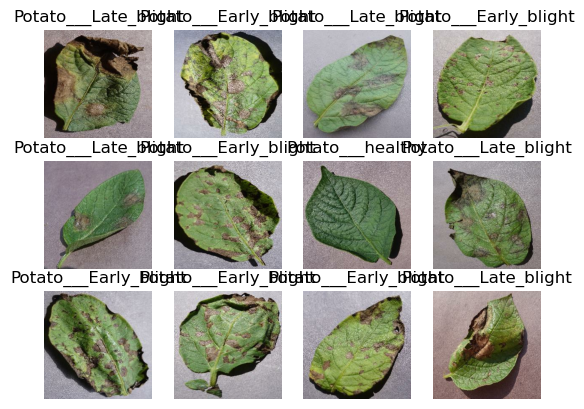

In [15]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
            ax = plt.subplot(3,4,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label_batch[i]])
            plt.axis("off")

In [16]:
len(dataset)

68

In [17]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds=dataset.take(54)
len(train_ds)

54

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [20]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [21]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [22]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

54

In [26]:
len(val_ds)


6

In [27]:
len(test_ds)

8

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [30]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [33]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model  = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 128)        

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 40s 742ms/step - loss: 2.5808e-06 - accuracy: 1.0000 - val_loss: 0.0348 - val_accuracy: 0.9948
Epoch 2/50
54/54 [==============================] - 39s 727ms/step - loss: 2.3769e-06 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 0.9948
Epoch 3/50
 9/54 [====>.........................] - ETA: 38s - loss: 2.6718e-06 - accuracy: 1.0000

KeyboardInterrupt: 

In [40]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 166ms/step - loss: 6.2278e-05 - accuracy: 1.0000


In [41]:
scores

[6.22781808488071e-05, 1.0]

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [44]:
history.history.key()

AttributeError: 'dict' object has no attribute 'key'

Text(0.5, 1.0, 'Training and Validation Loss')

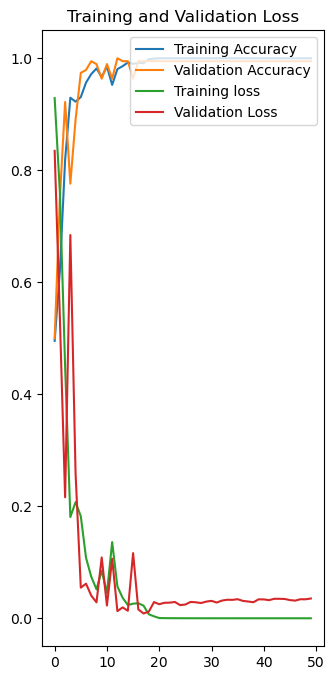

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label:  Potato___Late_blight
1/1 [==============================] - 0s 428ms/step
predicted label:  Potato___Late_blight


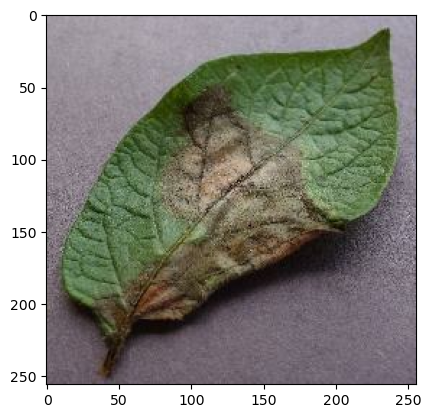

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label]);

    batch_prediction = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
        img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_array = tf.expand_dims(img_array,0)

        predictions = model.predict(img_array)

        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])),2)
        return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


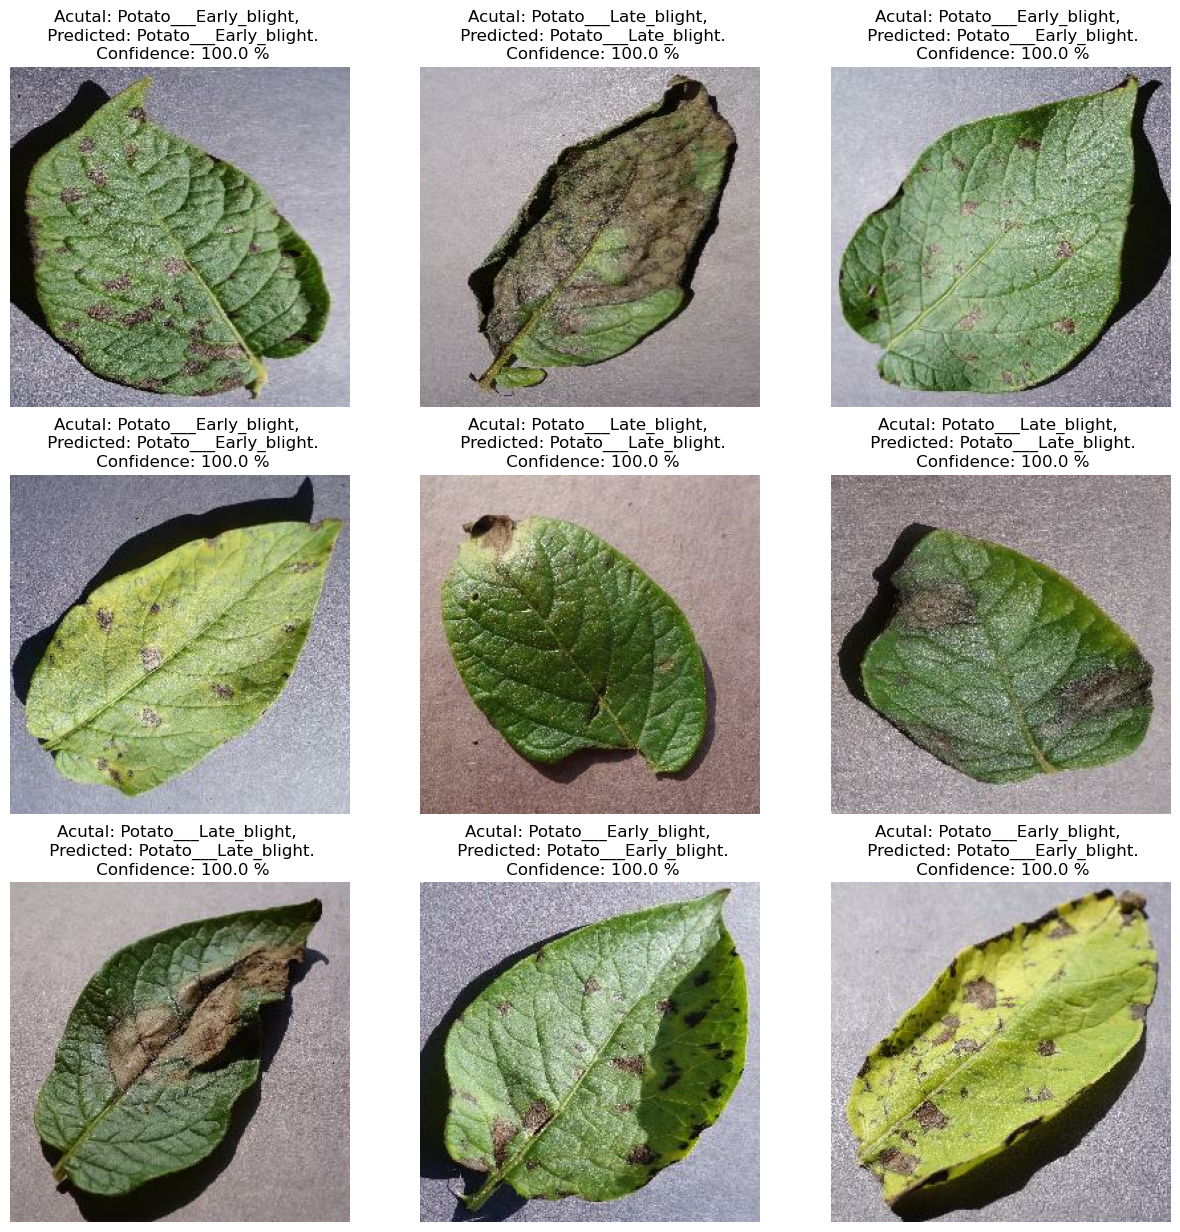

In [55]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]

            plt.title(f"Acutal: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence} %")
            plt.axis("off")
        

In [58]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
